In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from random import randint
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import json
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Extract data in a dataframe
reviews = []
scores = []
n = 0
with open("/drive/My Drive/6.7900 project/reviews_Amazon_Instant_Video_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        reviews.append(loaded["reviewText"])
        scores.append(loaded["overall"])
        n += 1

In [ ]:
# Count each rating
count = [0,0,0,0,0]
for score in scores:
    count[int(score) - 1] += 1
print(count)
balancer = [n / (5 * num)  for num in count]

[1718, 1885, 4187, 8446, 20890]


In [ ]:
# Create input and label
label = [[0.0,0.0,0.0,0.0,0.0] for _ in scores]
inp = reviews
for idx in range(len(scores)):
    curr_score = int(scores[idx]) - 1
    label[idx][curr_score] = 1.0

In [ ]:
# Randomize
for idx in range(1, n):
    rand = randint(0, idx)
    label[idx], label[rand] = label[rand], label[idx]
    inp[idx], inp[rand] = inp[rand], inp[idx]
label = np.array(label)
inp = np.array(inp)

In [ ]:
# Tokenize, encode, and pad
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(inp)
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Create custom loss function
class CustomAccuracy(keras.losses.Loss):
  def __init__(self):
      super().__init__()
  def call(self, y_true, y_pred):
      log_y_pred = tf.math.log(y_pred)
      original = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
      with_balance = tf.math.multiply_no_nan(x=original, y=balancer)
      return tf.reduce_mean(tf.reduce_sum(with_balance,axis=1))

In [ ]:
# Baseline Model
embedding_vector_length = 32
vocab_size = len(tokenizer.word_index)
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
baseline_model.add(SpatialDropout1D(0.25))
baseline_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(5, activation='softmax'))
baseline_model.compile(loss=CustomAccuracy(),optimizer='adam',metrics=['accuracy'])
print(baseline_model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 200, 32)           1908416   
                                                                 
 spatial_dropout1d_21 (Spati  (None, 200, 32)          0         
 alDropout1D)                                                    
                                                                 
 lstm_21 (LSTM)              (None, 50)                16600     
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 5)                 255       
                                                                 
Total params: 1,925,271
Trainable params: 1,925,271
Non-trainable params: 0
___________________________________________

In [ ]:
# Training
training = baseline_model.fit(padded_sequence,label,validation_split=0.2, epochs=25, batch_size=32)

Epoch 1/25
929/929 [==============================] - 270s 287ms/step - loss: 1.4465 - accuracy: 0.4098 - val_loss: 1.3620 - val_accuracy: 0.4111
Epoch 2/25
929/929 [==============================] - 272s 293ms/step - loss: 1.2787 - accuracy: 0.4880 - val_loss: 1.2909 - val_accuracy: 0.5650
Epoch 3/25
929/929 [==============================] - 267s 287ms/step - loss: 1.1998 - accuracy: 0.5232 - val_loss: 1.2538 - val_accuracy: 0.5396
Epoch 4/25
929/929 [==============================] - 270s 290ms/step - loss: 1.1427 - accuracy: 0.5380 - val_loss: 1.3436 - val_accuracy: 0.6027
Epoch 5/25
929/929 [==============================] - 268s 288ms/step - loss: 1.1032 - accuracy: 0.5494 - val_loss: 1.2708 - val_accuracy: 0.5890
Epoch 6/25
929/929 [==============================] - 269s 289ms/step - loss: 1.0717 - accuracy: 0.5612 - val_loss: 1.3596 - val_accuracy: 0.6138
Epoch 7/25
929/929 [==============================] - 287s 309ms/step - loss: 1.0322 - accuracy: 0.5704 - val_loss: 1.2792 -

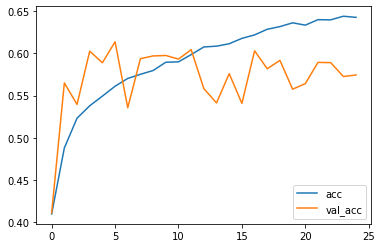

In [ ]:
# Plot Accuracy
plt.plot(training.history['accuracy'], label='acc')
plt.plot(training.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

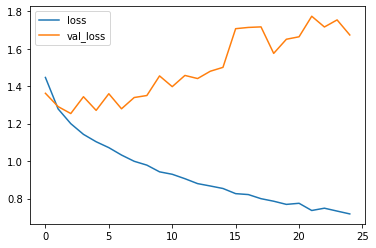

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = baseline_model.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
# Extract new data
reviews = []
scores = []
n = 0
with open("/drive/My Drive/6.7900 project/Digital_Music_5.json", "r") as file:
    for line in file:
        loaded = json.loads(line)
        if "reviewText" in loaded and "overall" in loaded:
            reviews.append(loaded["reviewText"])
            scores.append(loaded["overall"])
            n += 1

In [ ]:
# Randomize sequence
for idx in range(1, n):
    rand = randint(0, idx)
    scores[idx], scores[rand] = scores[rand], scores[idx]
    reviews[idx], reviews[rand] = reviews[rand], reviews[idx]

In [ ]:
# Find accuracy in new data
correct = 0
total = 10000
for idx in tqdm(range(total)):
    if predict_sentiment(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [12:56<00:00, 12.88it/s]

accuracy = 0.6145


In [ ]:
cap = 1000
# Create new input and label
label = [[0,0,0,0,0] for _ in range(cap)]
inp = reviews[total : total + cap]
for idx in range(total, total + cap):
    curr_score = int(scores[idx]) - 1
    label[idx - total][curr_score] = 1
label = np.array(label)

In [ ]:
# Encode and pad
encoded_docs = tokenizer.texts_to_sequences(inp)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
# Architecture
domain_adapt = keras.models.clone_model(baseline_model)
domain_adapt.set_weights(baseline_model.get_weights())
domain_adapt.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
domain_adapt.layers[0].trainable = False
print(domain_adapt.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 200, 32)           1908416   
                                                                 
 spatial_dropout1d_21 (Spati  (None, 200, 32)          0         
 alDropout1D)                                                    
                                                                 
 lstm_21 (LSTM)              (None, 50)                16600     
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 5)                 255       
                                                                 
Total params: 1,925,271
Trainable params: 16,855
Non-trainable params: 1,908,416
______________________________________

In [ ]:
# Training
training_adapt = domain_adapt.fit(padded_sequence,label,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 9s 243ms/step - loss: 0.7916 - accuracy: 0.7225 - val_loss: 0.6119 - val_accuracy: 0.7900
Epoch 2/10
25/25 [==============================] - 5s 219ms/step - loss: 0.6285 - accuracy: 0.8100 - val_loss: 0.5206 - val_accuracy: 0.8150
Epoch 3/10
25/25 [==============================] - 6s 221ms/step - loss: 0.5797 - accuracy: 0.8225 - val_loss: 0.5051 - val_accuracy: 0.8350
Epoch 4/10
25/25 [==============================] - 5s 219ms/step - loss: 0.5714 - accuracy: 0.8175 - val_loss: 0.5017 - val_accuracy: 0.8350
Epoch 5/10
25/25 [==============================] - 6s 228ms/step - loss: 0.5431 - accuracy: 0.8263 - val_loss: 0.5036 - val_accuracy: 0.8350
Epoch 6/10
25/25 [==============================] - 6s 221ms/step - loss: 0.5463 - accuracy: 0.8213 - val_loss: 0.4993 - val_accuracy: 0.8400
Epoch 7/10
25/25 [==============================] - 6s 222ms/step - loss: 0.5128 - accuracy: 0.8313 - val_loss: 0.4935 - val_accuracy: 0.8400
Epoch 

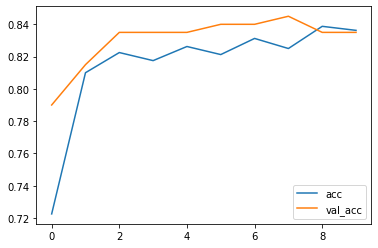

In [ ]:
# Plot Accuracy
plt.plot(training_adapt.history['accuracy'], label='acc')
plt.plot(training_adapt.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

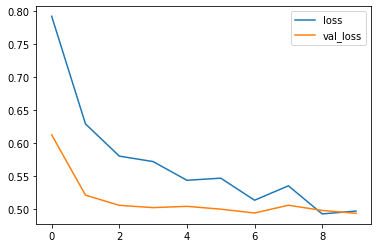

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Loss
plt.plot(training_adapt.history['loss'], label='loss')
plt.plot(training_adapt.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
# Make a sentiment analysis function for domain adapt
def predict_sentiment_adapt(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    dist = domain_adapt.predict(tw, verbose = 0)
    high_prob = 0
    score = 0
    for idx in range(5):
        if dist[0][idx] > high_prob:
            high_prob = dist[0][idx]
            score = idx
    score += 1
    return score

In [ ]:
correct = 0
for idx in tqdm(range(total)):
    if predict_sentiment_adapt(reviews[idx]) == int(scores[idx]):
        correct += 1
print("accuracy =", correct / total)

100%|██████████| 10000/10000 [12:40<00:00, 13.15it/s]

accuracy = 0.7971
